## Datasets. 3차원 공간 (i.e. 2 features)
## Regression? 
1. z = x + y
2. z = x * y
3. z = cos(x) + sin(y)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [2]:
x, y = np.meshgrid(np.linspace(0,1.5,130),np.linspace(0,1.5,130))

In [3]:
features = torch.from_numpy(np.column_stack((x.ravel(), y.ravel())))
features = features.to(dtype=torch.float32)
features.shape

torch.Size([16900, 2])

In [4]:
z1 = features[:,0] + features[:,1]
z1, z1.shape

(tensor([0.0000, 0.0116, 0.0233,  ..., 2.9767, 2.9884, 3.0000]),
 torch.Size([16900]))

In [5]:
z2 = (features[:,0]-0.5) * (features[:,1]-0.5)
z2.shape, z2

(torch.Size([16900]),
 tensor([0.2500, 0.2442, 0.2384,  ..., 0.9767, 0.9884, 1.0000]))

In [6]:
z3 = (features[:,0]*10).cos() + (features[:,1]*10).sin()
z3, z3.shape

(tensor([ 1.0000,  0.9932,  0.9731,  ...,  0.0609, -0.0288, -0.1094]),
 torch.Size([16900]))

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self,
                    input_features: int,
                    output_features: int,
                    hidden_units: int = 8,
                    only_linear: bool = False) -> None:
        '''
        Initializes multi-class classification model.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (Number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
            only_linear (bool): if ```True```, Not use Non-Linear activation Function

        Returns:
            None

        Example:
            ```
            model = BlobClassifier(input_features=3,
                                    ouput_features=4,
                                    hidden_units=8)
            ```
        '''
        super().__init__()

        # Layers
        if only_linear:
            self.linear_layer_stack = nn.Sequential(
                nn.Linear(in_features=input_features,
                            out_features=hidden_units),
                nn.Linear(in_features=hidden_units,
                            out_features=hidden_units),
                nn.Linear(in_features=hidden_units,
                            out_features=output_features)
            )
        else:
            self.linear_layer_stack = nn.Sequential(
                nn.Linear(in_features=input_features,
                            out_features=hidden_units),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units,
                            out_features=hidden_units),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units,
                            out_features=hidden_units),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units,
                            out_features=output_features)
            )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [8]:
class SimpleTransformer(nn.Module):
    def __init__(self,embed_dim):
        super().__init__()
        self.embed = nn.Linear(2,embed_dim) # b, 16

        self.qkv = nn.Linear(embed_dim, embed_dim*3)

        self.linear1 = nn.Linear(embed_dim, embed_dim)
        self.linear2 = nn.Linear(embed_dim, 1)

        self.ln = nn.LayerNorm([embed_dim])

        self.act = nn.PReLU()

    def forward(self, x):
        batch_size = x.shape[0]
        # x,y -> 16 feature 
        x = self.embed(x)
        # 16 -> 16 * 3 (qkv) 16 16 16
        qkv = self.qkv(x).reshape(batch_size, 3, -1).permute(1,0,2).unsqueeze(-1) # batch 48a
        # 16 16 * 16 * 1
        q, k, v = qkv[0],qkv[1],qkv[2]

        attention = q @ k.transpose(1,2)

        attention = attention.softmax(dim=-1)

        x = attention @ v

        x = x.squeeze()


        
        x = self.linear1(x)
        x = self.act(x)


        x = self.linear2(x)
        
        return x

In [9]:
class Multiple(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(2,8)
        self.l1 = nn.Linear(8, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)

        self.head = nn.Linear(8,1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        
        wx1 = self.act(self.l1(x)) + x

        x2 = wx1 * x
        wx2 = self.act(self.l2(x2)) + wx1

        x3 = wx2 * x
        wx3 = self.act(self.l2(x3)) + wx2

        out = self.head(wx3)

        return out

In [10]:
torch.ones(32,16,16).flatten(1).shape

torch.Size([32, 256])

In [11]:
from torchinfo import summary

model = Multiple()


summary(model,input_size=(32,2))

Layer (type:depth-idx)                   Output Shape              Param #
Multiple                                 [32, 1]                   72
├─Linear: 1-1                            [32, 8]                   24
├─Linear: 1-2                            [32, 8]                   72
├─ReLU: 1-3                              [32, 8]                   --
├─Linear: 1-4                            [32, 8]                   72
├─ReLU: 1-5                              [32, 8]                   --
├─Linear: 1-6                            [32, 8]                   (recursive)
├─ReLU: 1-7                              [32, 8]                   --
├─Linear: 1-8                            [32, 1]                   9
Total params: 249
Trainable params: 249
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

## Train

In [12]:
import torch
import torch.nn as nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# model1 = SimpleTransformer(embed_dim=16).to(device)
# model2 = SimpleTransformer(embed_dim=16).to(device)
model1 = Multiple().to(device)
model2 = Multiple().to(device)
model3 = Multiple().to(device)

# model1 = SimpleMLP(input_features=2,
#                   output_features=1,
#                   hidden_units=64).to(device)
# model2 = SimpleMLP(input_features=2,
#                   output_features=1,
#                   hidden_units=64).to(device)
# model3 = SimpleMLP(input_features=2,
#                   output_features=1,
#                   hidden_units=64).to(device)


features = features.to(device)
z1, z2, z3 = z1.to(device), z2.to(device), z3.to(device)

loss_fn = nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-1)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-1)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=1e-1)

In [13]:
## Train Test Split
X_train = features[:11000]
z1_train = z1[:11000].unsqueeze(1)
z2_train = z2[:11000].unsqueeze(1)
z3_train = z3[:11000].unsqueeze(1)

X_test = features[11000:]
z1_test = z1[11000:].unsqueeze(1)
z2_test = z2[11000:].unsqueeze(1)
z3_test = z3[11000:].unsqueeze(1)

X_train.shape, z1_train.shape, z2_train.shape, z3_train.shape, X_test.shape, z1_test.shape, z2_test.shape, z3_test.shape


(torch.Size([11000, 2]),
 torch.Size([11000, 1]),
 torch.Size([11000, 1]),
 torch.Size([11000, 1]),
 torch.Size([5900, 2]),
 torch.Size([5900, 1]),
 torch.Size([5900, 1]),
 torch.Size([5900, 1]))

In [14]:
def train_epoch(epoch,model, loss_fn, optimizer, X_train, X_test, y_train, y_test):
    model.train()
    logit = model(X_train)
    loss = loss_fn(logit, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    test_logit = model(X_test)
    test_loss = loss_fn(test_logit, y_test)
    if epoch % 100 ==0:
        print(f'Epoch:{epoch} | TestLoss: {test_loss} | TrainLoss: {loss}')

In [15]:
# modelc.train()
# out = modelc(X_train)
# optimizer1.zero_grad()
# loss = loss_fn(out,z1_train)
# loss.backward()
# print(out, loss, modelc.embed.weight.grad)

# optimizer1.step()



In [26]:
epochs = 1000



print('Training Model1 | z = x + y')
for epoch in range(epochs):
    
    train_epoch(epoch=epoch,model=model1,
                loss_fn=loss_fn,
                optimizer=optimizer1,
                X_train=X_train,
                X_test=X_test,
                y_train=z1_train,
                y_test=z1_test)
    
print('Training Model2 | z = x * y')
for epoch in range(epochs):

    train_epoch(epoch=epoch,model=model2,
                loss_fn=loss_fn,
                optimizer=optimizer2,
                X_train=X_train,
                X_test=X_test,
                y_train=z2_train,
                y_test=z2_test)
    
print('Training Model1 | z = cos(x) + cos(y)')
for epoch in range(epochs):

    train_epoch(epoch=epoch,model=model3,
                loss_fn=loss_fn,
                optimizer=optimizer3,
                X_train=X_train,
                X_test=X_test,
                y_train=z3_train,
                y_test=z3_test)

Training Model1 | z = x + y
Epoch:0 | TestLoss: nan | TrainLoss: nan
Epoch:100 | TestLoss: nan | TrainLoss: nan
Epoch:200 | TestLoss: nan | TrainLoss: nan
Epoch:300 | TestLoss: nan | TrainLoss: nan
Epoch:400 | TestLoss: nan | TrainLoss: nan
Epoch:500 | TestLoss: nan | TrainLoss: nan
Epoch:600 | TestLoss: nan | TrainLoss: nan
Epoch:700 | TestLoss: nan | TrainLoss: nan
Epoch:800 | TestLoss: nan | TrainLoss: nan
Epoch:900 | TestLoss: nan | TrainLoss: nan
Training Model2 | z = x * y
Epoch:0 | TestLoss: 0.001337310648523271 | TrainLoss: 3.466570706223138e-05
Epoch:100 | TestLoss: 0.0013189390301704407 | TrainLoss: 3.20274630212225e-05
Epoch:200 | TestLoss: 0.0013044303050264716 | TrainLoss: 3.433018719078973e-05
Epoch:300 | TestLoss: 0.0012986987130716443 | TrainLoss: 3.834142262348905e-05
Epoch:400 | TestLoss: 0.0012986717047169805 | TrainLoss: 3.887002094415948e-05
Epoch:500 | TestLoss: 0.0012973030097782612 | TrainLoss: 3.426576222409494e-05
Epoch:600 | TestLoss: 0.0012921674642711878 | 

In [27]:
def plot3d(X, X_train, X_test, y, model, title):
    y_train = model(X_train)
    y_test = model(X_test)

    X, X_train, X_test = X.cpu().numpy(), X_train.cpu().numpy(), X_test.cpu().numpy()
    y, y_train, y_test = y.detach().cpu().numpy(), y_train.detach().cpu().numpy(), y_test.detach().cpu().numpy()


    fig = plt.figure(figsize=(24,24))
    ax = fig.add_subplot(projection='3d')


    ax.scatter(X[:,0],X[:,1],y, label='true')
    ax.scatter(X_train[:,0],X_train[:,1],y_train, label='train')
    ax.scatter(X_test[:,0],X_test[:,1],y_test, label='test')
    fig.legend(fontsize='20')
    plt.title(title, fontsize='30')
    plt.show()
    

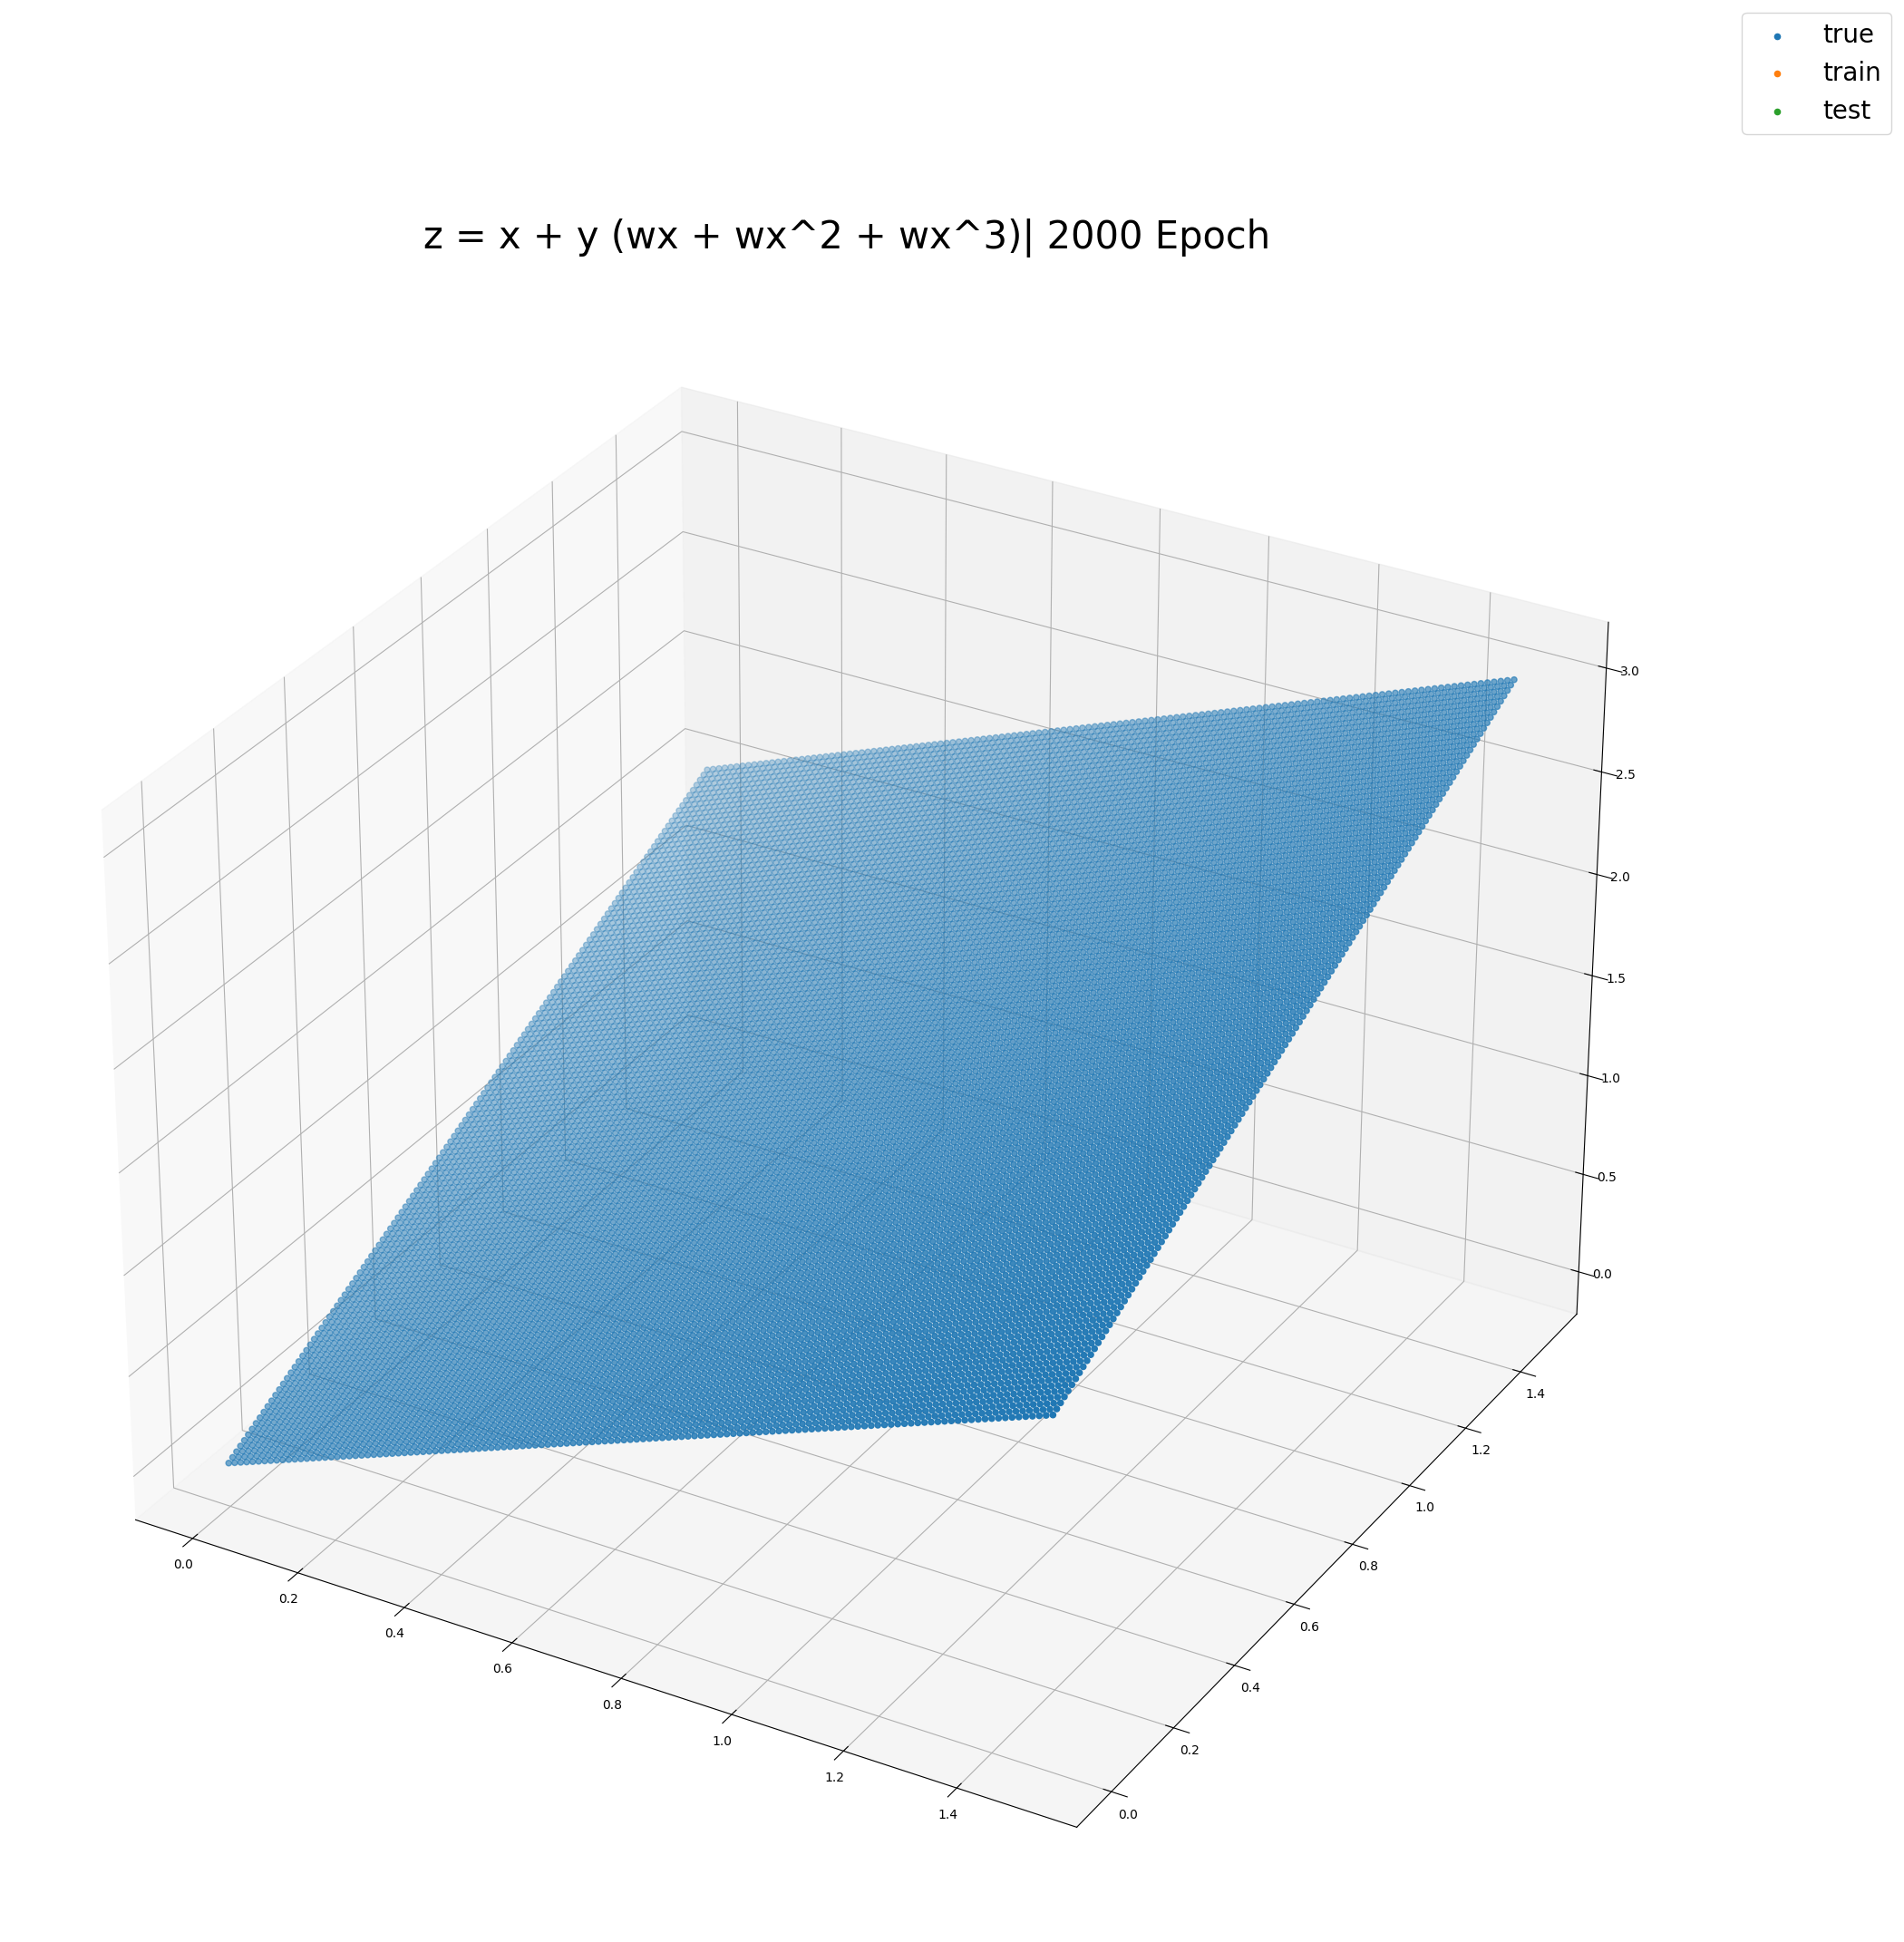

In [28]:
plot3d(features, X_train, X_test, z1, model1,'z = x + y (wx + wx^2 + wx^3)| 2000 Epoch')

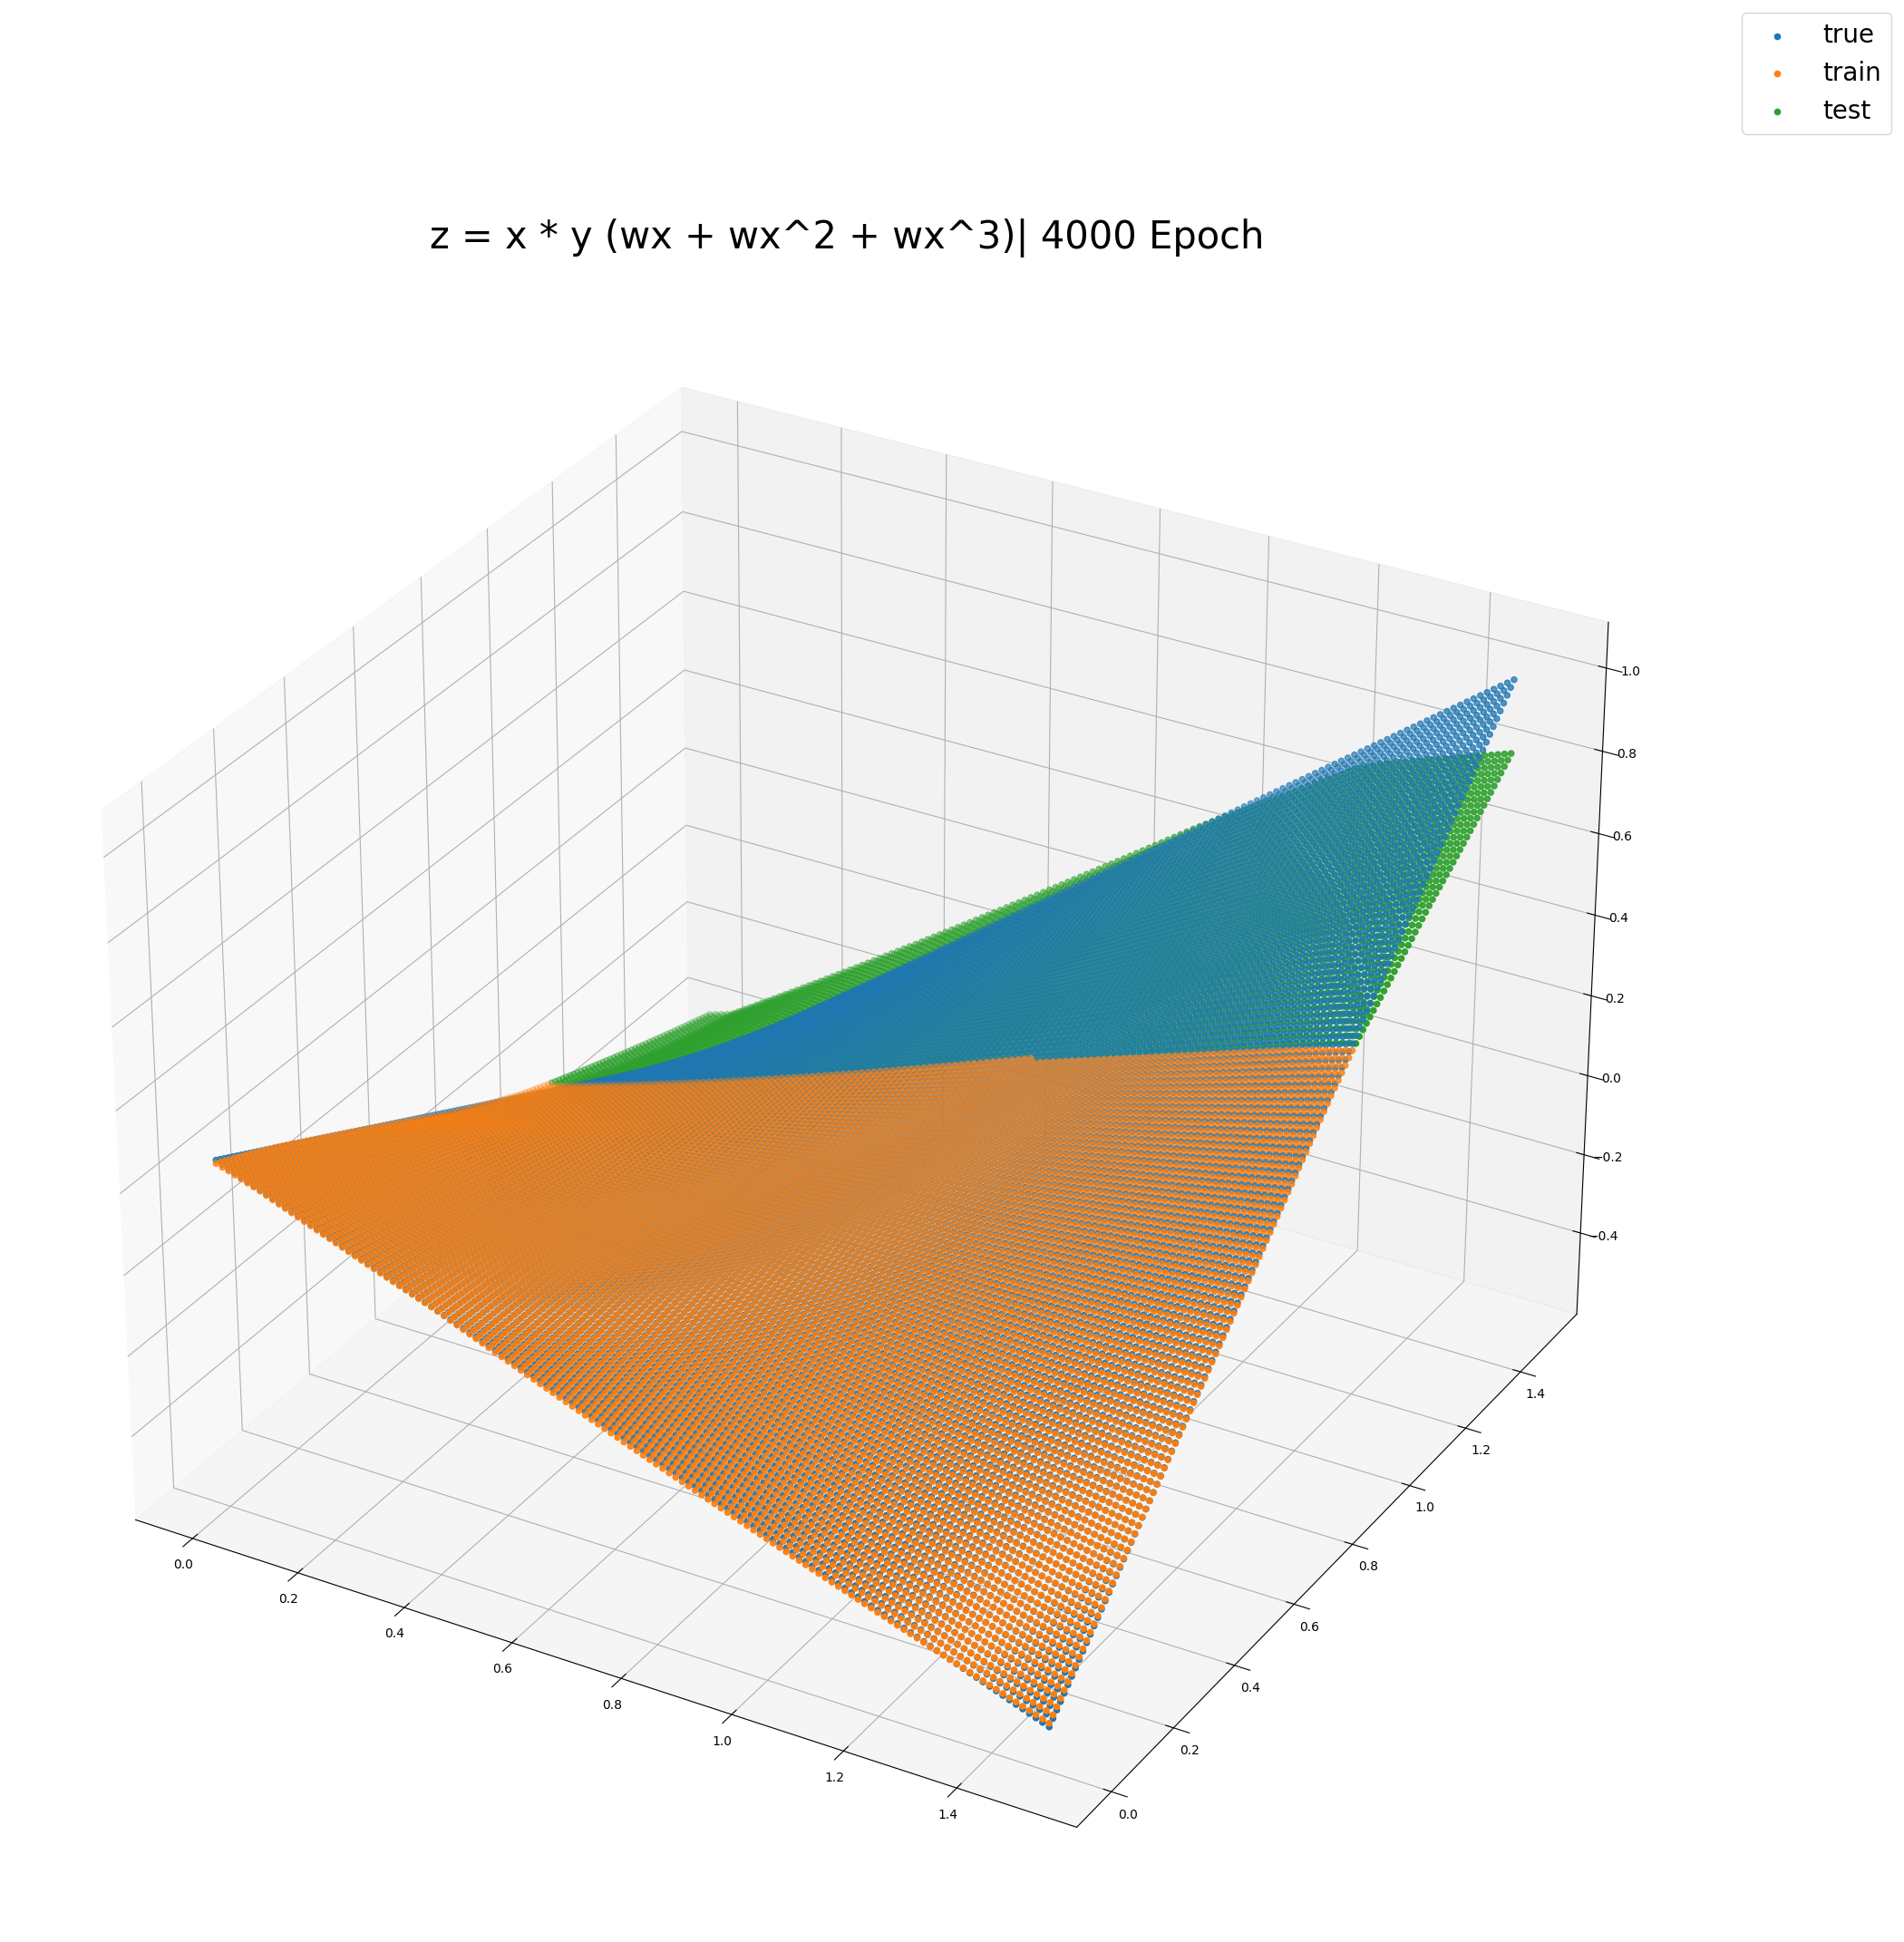

In [29]:
plot3d(features, X_train, X_test, z2, model2,'z = x * y (wx + wx^2 + wx^3)| 4000 Epoch')

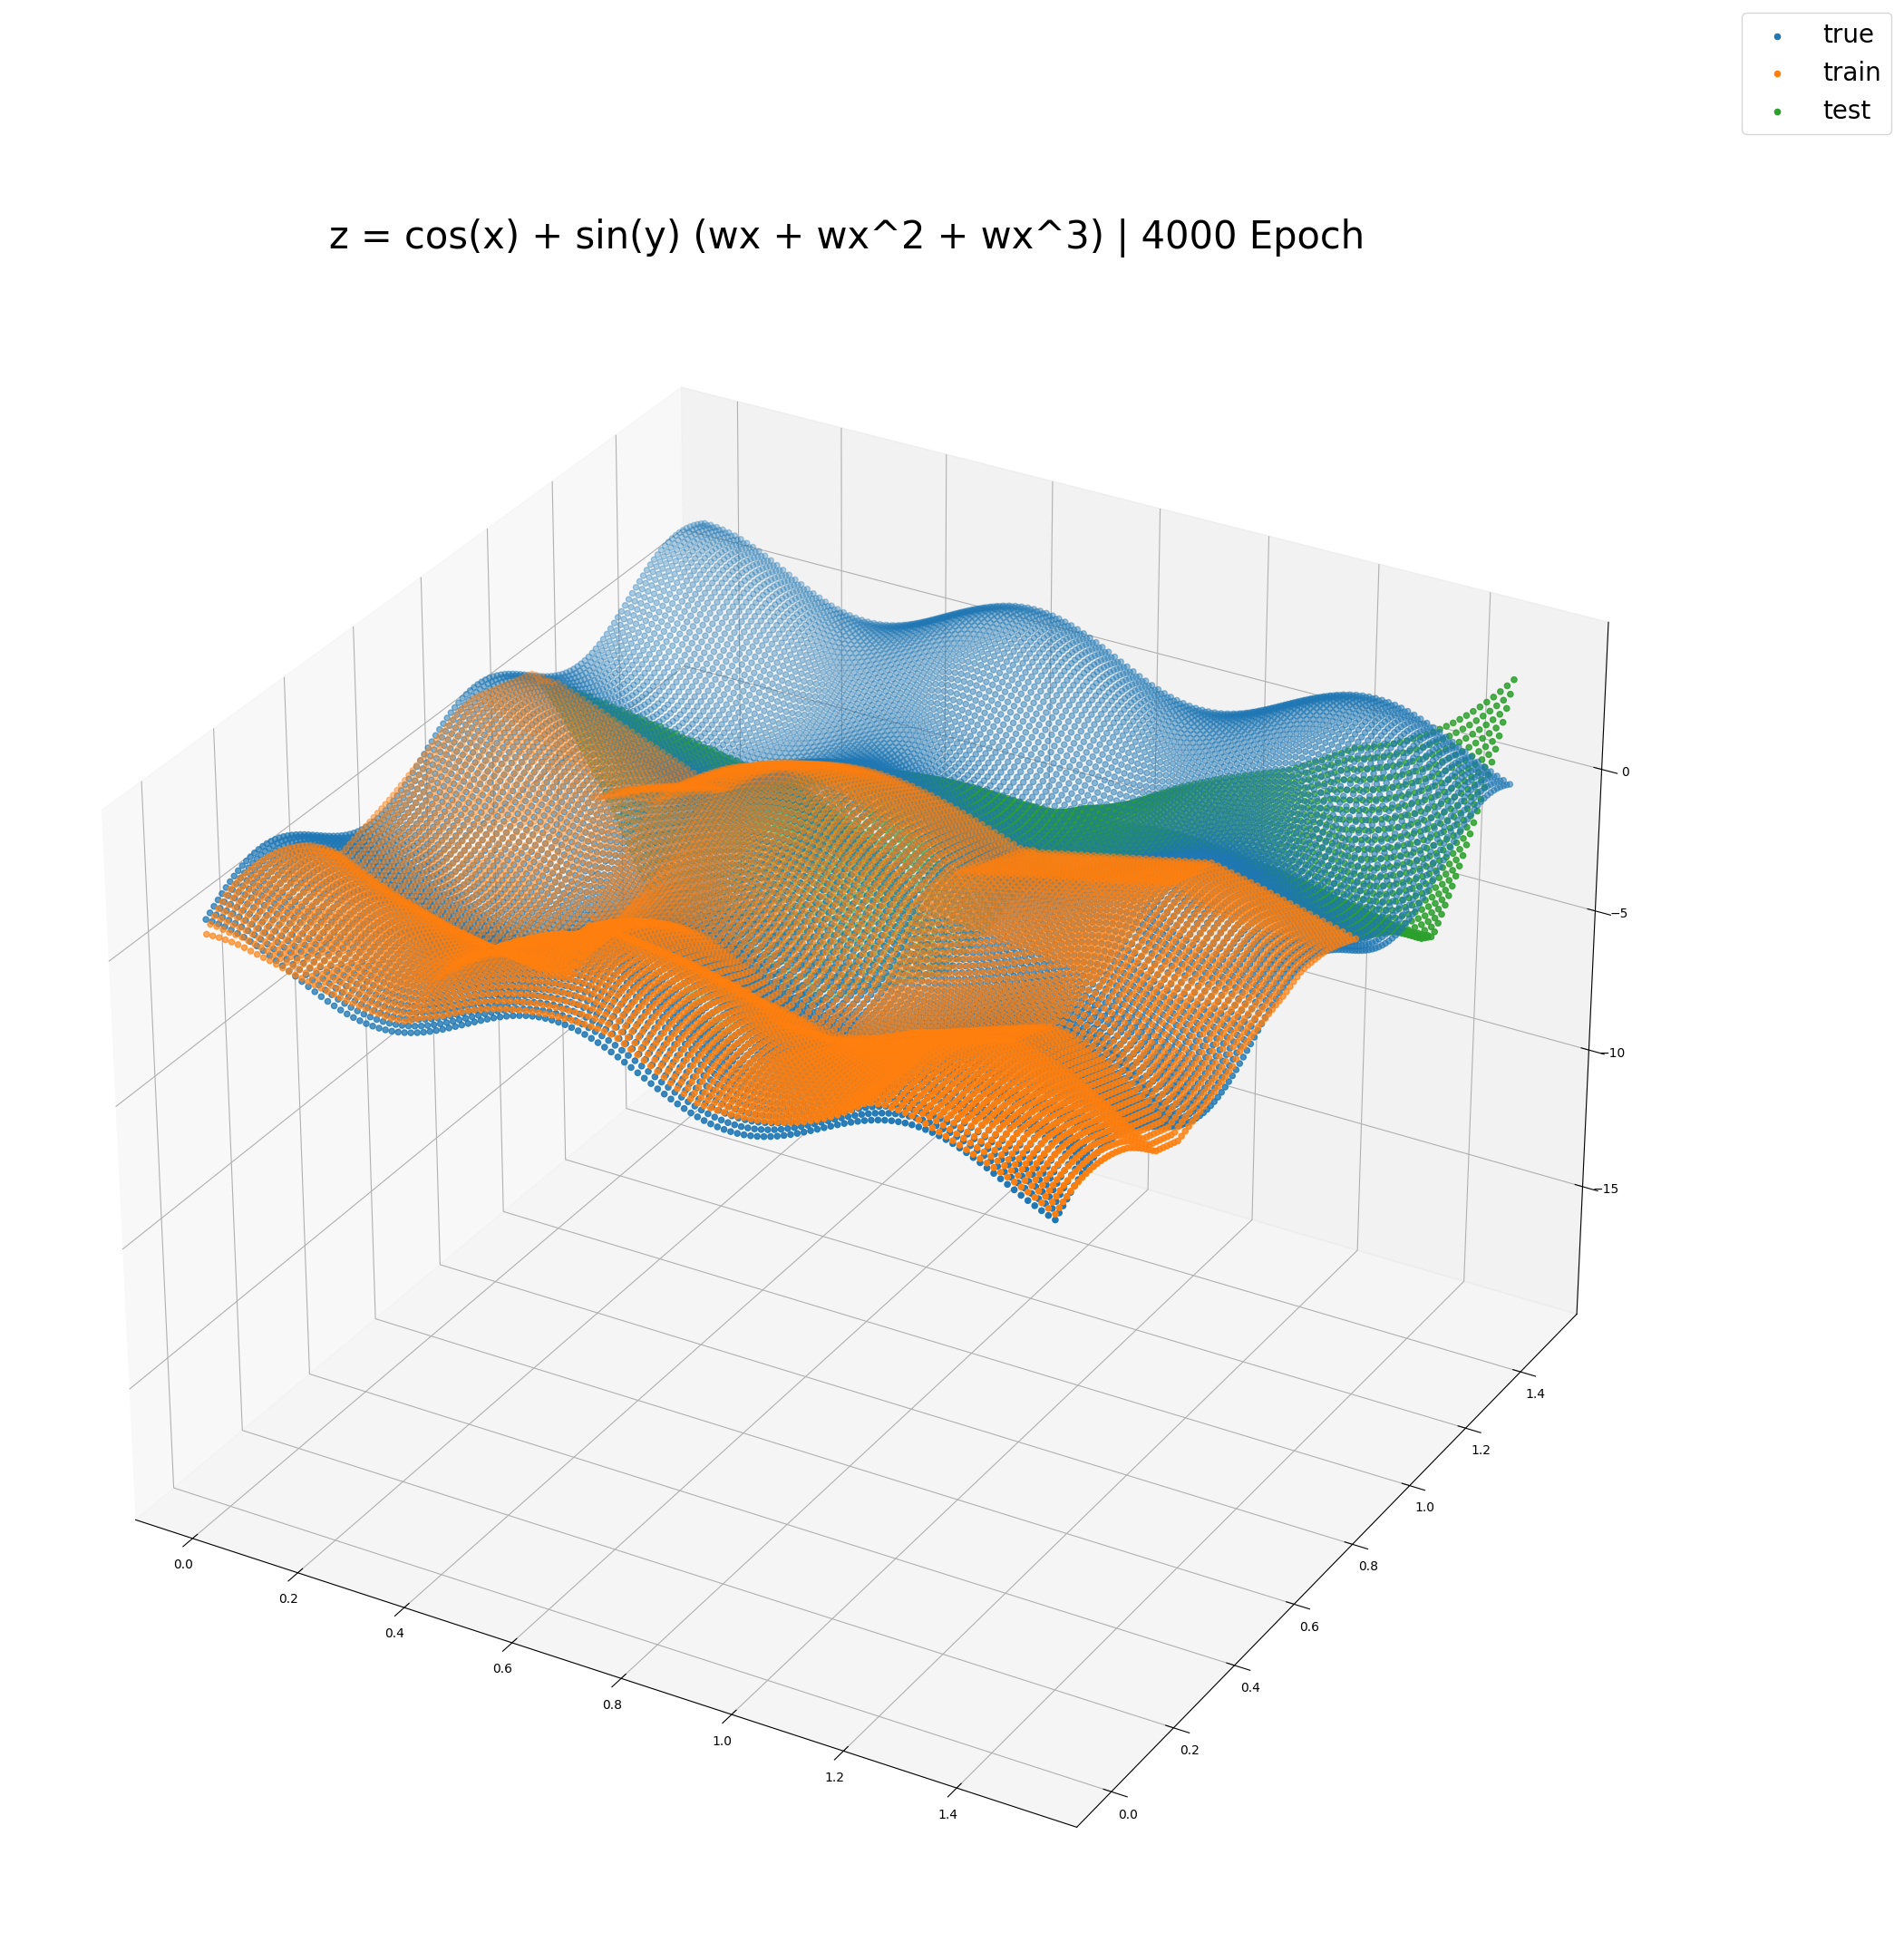

In [30]:
plot3d(features, X_train, X_test, z3, model3,'z = cos(x) + sin(y) (wx + wx^2 + wx^3) | 4000 Epoch')

In [7]:
theta = 2/5
(1/3 * pow(theta,3) - 3/4 * pow(theta,4) + 3/5*pow(theta,5) - 1/6*pow(theta,6))

0.007594666666666668

In [11]:
(pow(theta,2)-3*pow(theta,3)+3*pow(theta,4)-pow(theta,5))*5/2

0.08639999999999995

In [19]:
import math

lam = 20
k = 20

pow(lam,k) * math.exp(-lam) / math.factorial(k)

0.08883531739208521

In [18]:
math.exp(-20)

2.061153622438558e-09